In [88]:
#Nolan Winkler, Predicting Housing Prices

#uses some of 
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
#sklearn tutorial

#import libraries and tools
import pandas as pd
import numpy as np
import csv as csv 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sklearn as skl
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

#My process:

#The data I was given was very clean, so I did not have to do any replacements.
#After looking at the data for a while (mostly scatterplots of MEDV vs. another variable),
#I found that RM and DIS seemed to be in linear relationships with MEDV while LSTAT was in 
#more of a logarithmic relationship with it. As such, I wanted to see how well a simple
#linear regression of those last 3 variables predicting MEDV would perform, which I did
#after standardizing the data; I got an MSPE of 0.508. 

#I decided I would account for how
#there seemed to be some amount of different categories of houses based on thresholds for
#crime, blacks, tax values, and radius. For example, it seemed like there was a split 
#between houses with low-medium amounts of crime comprising one sample and houses in high
#crime areas (>25 per capital crime rate) comprising another. Thus, I decided that a 
#decision tree would be good because it could split up the data based on these thresholds.
#That gave me an MPSE of .610
#Finally, I did a gradient boosting regression on this data because that is apparently 
#the hot trend on Kaggle. This gave me a MSPE on the validation set of 1.4526.

#My impression is that the number of rooms is the most predictive, with the lower status
#% and distance variables also being important. Intuitively, lower status % seems like it
#would be very important as housing property values tend to be similar based on the block/
#neighborhood that one is on and 'birds of a feather flock together'.


In [87]:
#get out the data
df_full = pd.read_csv('trainHousing.csv')

df_full

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.97617,0.0,21.89,0,0.6240,5.757,98.4,2.3460,4,437,21.2,262.76,17.31,15.6
1,0.07875,45.0,3.44,0,0.4370,6.782,41.1,3.7886,5,398,15.2,393.87,6.68,32.0
2,0.04590,52.5,5.32,0,0.4050,6.315,45.6,7.3172,6,293,16.6,396.90,7.60,22.3
3,4.66883,0.0,18.10,0,0.7130,5.976,87.9,2.5806,24,666,20.2,10.48,19.01,12.7
4,0.11432,0.0,8.56,0,0.5200,6.781,71.3,2.8561,5,384,20.9,395.58,7.67,26.5
5,6.71772,0.0,18.10,0,0.7130,6.749,92.6,2.3236,24,666,20.2,0.32,17.44,13.4
6,3.56868,0.0,18.10,0,0.5800,6.437,75.0,2.8965,24,666,20.2,393.37,14.36,23.2
7,0.06724,0.0,3.24,0,0.4600,6.333,17.2,5.2146,4,430,16.9,375.21,7.34,22.6
8,0.26938,0.0,9.90,0,0.5440,6.266,82.8,3.2628,4,304,18.4,393.39,7.90,21.6
9,1.13081,0.0,8.14,0,0.5380,5.713,94.1,4.2330,4,307,21.0,360.17,22.60,12.7


In [48]:
df_full['MEDV']
print('\n')
df_full.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.637475,11.718927,11.054831,0.059322,0.556663,6.280280,69.241525,3.757012,9.807910,408.920904,18.418079,358.676017,12.672232,22.544068
std,8.271806,23.519914,6.788581,0.236561,0.118053,0.698457,27.159878,2.080239,8.772694,170.942942,2.197748,89.240469,7.158513,9.190664
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,4.995000,0.000000,0.449000,5.885750,45.925000,2.105725,4.000000,277.000000,17.000000,376.602500,7.375000,16.875000
50%,0.257780,0.000000,9.690000,0.000000,0.538000,6.209000,77.150000,3.231000,5.000000,329.000000,19.100000,392.215000,11.235000,21.400000
75%,3.755473,19.375000,18.100000,0.000000,0.647000,6.630000,93.550000,5.091050,24.000000,666.000000,20.200000,396.120000,17.002500,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [49]:
#look at a histogram of quantity we want to predict
n, bins, patches = plt.hist(df_full.MEDV, bins=10)

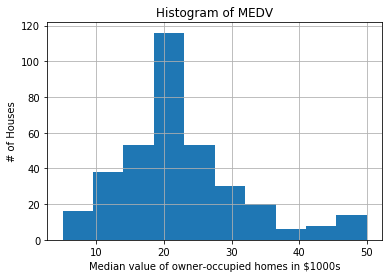

In [50]:
plt.xlabel('Median value of owner-occupied homes in $1000s')
plt.ylabel('# of Houses')
plt.title('Histogram of MEDV')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [51]:
#See which rows have nulls
df_full[df_full.isnull().any(axis=1)]
#hey, it's none! yay!

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV


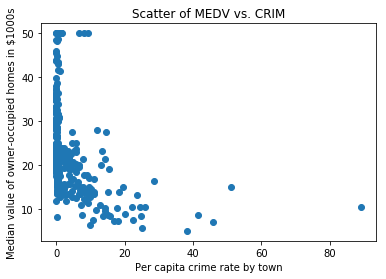

In [52]:
#investigate which variables seem to be correlated with median housing value
plt.scatter(df_full.CRIM, df_full.MEDV)
plt.xlabel('Per capita crime rate by town')
plt.ylabel('Median value of owner-occupied homes in $1000s')
plt.title('Scatter of MEDV vs. CRIM')
plt.show()
#seemingly have two classes/samples if we get high or low enough: blacks, crime, tax

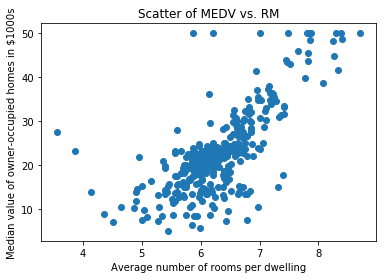

In [53]:
plt.scatter(df_full.RM, df_full.MEDV)
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')
plt.title('Scatter of MEDV vs. RM')
plt.show()
#seemingly linear: room, distance

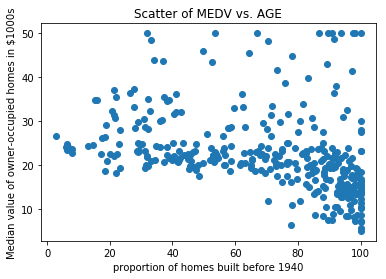

In [54]:
plt.scatter(df_full.AGE, df_full.MEDV)
plt.xlabel('proportion of homes built before 1940')
plt.ylabel('Median value of owner-occupied homes in $1000s')
plt.title('Scatter of MEDV vs. AGE')
plt.show()

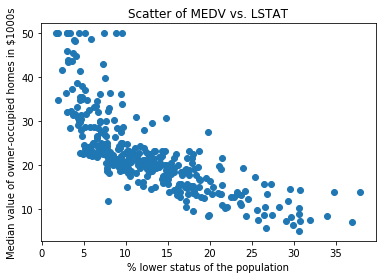

In [55]:
plt.scatter(df_full.LSTAT, df_full.MEDV)
plt.xlabel('% lower status of the population')
plt.ylabel('Median value of owner-occupied homes in $1000s')
plt.title('Scatter of MEDV vs. LSTAT')
plt.show()
#logarithmic

In [56]:
#turn pandas df into numpy array
df_full.dtypes
df_full

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.97617,0.0,21.89,0,0.6240,5.757,98.4,2.3460,4,437,21.2,262.76,17.31,15.6
1,0.07875,45.0,3.44,0,0.4370,6.782,41.1,3.7886,5,398,15.2,393.87,6.68,32.0
2,0.04590,52.5,5.32,0,0.4050,6.315,45.6,7.3172,6,293,16.6,396.90,7.60,22.3
3,4.66883,0.0,18.10,0,0.7130,5.976,87.9,2.5806,24,666,20.2,10.48,19.01,12.7
4,0.11432,0.0,8.56,0,0.5200,6.781,71.3,2.8561,5,384,20.9,395.58,7.67,26.5
5,6.71772,0.0,18.10,0,0.7130,6.749,92.6,2.3236,24,666,20.2,0.32,17.44,13.4
6,3.56868,0.0,18.10,0,0.5800,6.437,75.0,2.8965,24,666,20.2,393.37,14.36,23.2
7,0.06724,0.0,3.24,0,0.4600,6.333,17.2,5.2146,4,430,16.9,375.21,7.34,22.6
8,0.26938,0.0,9.90,0,0.5440,6.266,82.8,3.2628,4,304,18.4,393.39,7.90,21.6
9,1.13081,0.0,8.14,0,0.5380,5.713,94.1,4.2330,4,307,21.0,360.17,22.60,12.7


In [78]:
#all good - numerical

train_set = df_full.values
train_set

#split off validation set from train set to try and minimize MSPE on this as we can't
#actually tell if we do so on the test set

train_data, validation_data = skl.model_selection.train_test_split(train_set)

In [85]:
#Get testing data too
df_test = pd.read_csv('testHousing.csv')

df_test.count()
#deal with nulls - there's none.
df_test[df_test.isnull().any(axis=1)]

test_data = df_test.values

In [94]:
#creating a model from the train set
from sklearn import preprocessing
#separate the features and the value we're predicting
X_orig_OLS = train_data[:, [5, 7, 12]]
Y_orig_OLS = np.ravel(train_data[:, [13]])
#Normalize the data
X_OLS = preprocessing.scale(X_orig_OLS)
Y_OLS = preprocessing.scale(Y_orig_OLS)

#going to test the error on the validation set

X_validation_OLS = preprocessing.scale(validation_data[:, [5, 7, 12]])
Y_validation = preprocessing.scale(validation_data[:, [13]])
print(np.shape(X_validation_OLS))
print(np.shape(Y_validation))

#print(X_orig)
#print('\n')
#print(Y_orig)
#print('\n')
#print('\n')
#print(X)
#print('\n')
#print(Y)

(89, 3)
(89, 1)


In [97]:
#run an OLS regression on room, distance, and lower status
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_OLS, Y_OLS)

[[ -1.02083628e+00  -1.18041987e+00   1.51075226e+00]
 [ -3.28688329e-01  -2.60561975e-01  -3.28490344e-01]
 [  9.31787064e-02   1.49217611e+00  -6.70706721e-01]
 [  8.63979832e-01   7.13229388e-02  -1.30060300e+00]
 [  2.04723211e-01   1.36094088e+00  -9.99288980e-01]
 [  4.86444587e-01   6.41732664e-01  -4.11658467e-01]
 [  1.76122056e-01  -3.49822432e-01  -2.75317281e-01]
 [ -3.04377347e-01   8.71685490e-01  -6.14806835e-01]
 [  8.72560178e-01  -5.58531642e-01  -7.63418728e-01]
 [ -1.08459436e-01  -1.16574500e+00   1.58710332e+00]
 [ -5.44627048e-01   5.20327262e-01  -3.70756111e-01]
 [ -1.21103396e+00  -1.30098670e+00   1.94977088e+00]
 [ -4.05911447e-01  -1.24341946e-01  -3.25763520e-01]
 [  1.19861334e+00   1.48756401e+00  -6.36621425e-01]
 [  1.74489540e+00  -5.78703760e-01  -1.27606159e+00]
 [  1.32731854e+00   1.10205760e+00  -1.31560053e+00]
 [  6.82362498e-01  -6.22588598e-01  -4.22565762e-01]
 [ -5.21746124e-01   1.11053641e+00  -5.08460709e-01]
 [  5.43646896e-01   1.50706

In [105]:
#see our results
from sklearn.metrics import mean_squared_error
MSPE_OLS = mean_squared_error(regr.predict(X_validation_OLS), Y_validation)**0.5
print(MSPE_OLS)



# The coefficients
print('Coefficients: \n', regr.coef_)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_validation_OLS, Y_validation))

0.507546367268
Coefficients: 
 [ 0.39967284 -0.13329919 -0.54168683]
Variance score: 0.74


In [66]:
#seemingly have two classes/samples if we get high or low enough: blacks, crime, tax
#Therefore, run a decision tree regression on room, distance, lower status, crime,
#blacks, radius, lower status, and tax
X_original_DT = train_data[:, [0, 5, 7, 8, 10, 11, 12]]
Y_original_DT = train_data[:, [13]]
X_DT = preprocessing.scale(X_original_DT)
Y_DT = preprocessing.scale(Y_original_DT)


In [69]:
X_validation_DT = preprocessing.scale(validation_data[:, [0, 5, 7, 8, 10, 11, 12]])
Y_validation_DT = preprocessing.scale(validation_data[:, [13]])

In [70]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_DT, Y_DT)


# In[45]:

#see our results
predics = clf.predict(X_validation_DT)
MSPE_DT = mean_squared_error(predics, Y_validation_DT)**0.5
print(MSPE_DT)

##decision tree actually performs worse than regular OLS

0.610236514707


In [72]:
#going to try gradient boost because Kaggle says so

X_orig_GradBoost = train_data[:, :-1]
Y_orig_GradBoost = np.ravel(train_data[:, -1:])



X_validation_GB = validation_data[:, :-1]
#print(np.shape(X_test))
#print('\n')

#NaN's don't work in predictions so I'll change them to 0

Y_validation_GB = validation_data[:, -1:]


In [73]:
#Fitting gradient boost regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

#seeing the RMSError on the train set
clf.fit(X_orig_GradBoost, Y_orig_GradBoost)
mse = mean_squared_error(Y_validation_GB, clf.predict(X_validation_GB))
print("MSE: %.4f" % mse)

MSE: 10.2772


In [91]:
#since regular OLS worked best, these would be our predicted values

X_test = test_data[:, [5, 7, 12]]
#Normalize the data
X_test_norm = preprocessing.scale(X_test)
print(regr.predict(X_test))

[ -0.61494518  -3.04682874   0.02654102   0.39626489  -0.83881538
  -8.69971887 -14.77286809  -5.61656422  -1.79190078  -6.12008011
  -4.65777441  -8.21570443  -8.99132281 -13.16395244  -1.44421008
  -3.93956066  -6.03224079  -7.34784489  -1.16623061  -3.07757629
  -1.79912094  -0.89704294  -5.72108889  -3.6742089   -3.18186483
  -0.89683308  -1.84130621  -3.29460769  -2.61976144  -5.18934609
  -4.53693355  -6.86394437  -6.73118432  -3.46186305  -3.53917037
  -5.62314697  -5.89559228  -7.27463807  -7.94549973  -4.41547261
  -3.78708274  -6.14389345  -6.93643579  -7.04183759  -7.7635876
 -16.82535669 -12.79806424 -13.47176212  -5.24592806  -5.97390363
  -1.29287753  -0.72104757  -3.17991917   0.89204788  -4.48482804
  -0.68846544  -1.32549624  -0.3174886   -5.73129994  -0.8359771
  -0.27195008  -0.57903272   0.52107834   0.96868827  -3.99447879
  -6.08259476 -10.88823162 -14.32202727  -3.18491541  -2.8631155
  -3.06576903   0.59331434   1.08923966  -1.01092189   0.49857498
  -2.15917477